In [1]:
import numpy as np
import scipy.stats as ss
from numpy import Inf
import matplotlib.pyplot as plt
import sys
import pyEXP
##  exp
#sys.path.append("/u/svarel/exp/build/utils/Analysis/")
from spherical_basis_builder import *
#import simpleSL

## Auriga
import LibAu as la

In [14]:
from scipy.optimize import curve_fit,leastsq
def HeightPro(z,m,p0=None,bounds=((0,0),(np.inf,np.inf))):
    sech = lambda z_: 1/np.cosh(z_)
    Iz = lambda zz,hz,Io: Io* sech(zz/hz)**2

    popt,pcov = curve_fit(Iz,z,m,bounds=bounds)
    hz,Io = popt

    Z_fit =Iz(z,hz,Io)
    residuals = m - Z_fit
    chi_sq = sum((residuals**2)/Z_fit)

    Lib = {'h_z':hz,'I0':Io,
            'SechFit':(z,Z_fit),
            'ChiSquare':chi_sq, 'pcov':pcov}
    return Lib

In [3]:
nhalo=21 #Name Halo
nsnap= 63 #z=0
sim = la.Reader_Au(Nhalo=nhalo,Nsnap=nsnap) #Read Simulation
header = sim.Header()
h=header['hubbleparam']
sc=header['time']

Rvir = sim.sf.data['frc2'][0]*1000*sc/h
Mvir = sim.sf.data['fmc2'][0]*1e10/h
Npart = sim.sf.data['slty'][0]
Rhalf = sim.sf.data['shmt'][0][4]*1000*sc/h
print(Mvir,Rvir,Npart,Rhalf)


fields_stars = ['pos','vel','id','mass','type','pot','age']
Datstars = sim.Snapshot_Subhalo(idSubhalo=0,snapType='stars',fields=fields_stars)


fields_dm = ['pos','vel','id','mass','type','pot']
DatDM = sim.Snapshot_Subhalo(idSubhalo=0,snapType='dm1',fields=fields_dm)
#Rotate Halo
Data = {'stars':Datstars,'dm1':DatDM}
param = {'spos':sim.sf.data['spos'][0,:],'svel':sim.sf.data['svel'][0,:],'header':sim.Header()}
gal = la.ToolRot(Data=Data, param=param)
Data = gal.Rotate()

Datstars=Data['stars']
DatDM = Data['dm1']

potdm = np.float64(DatDM['pot'])
pos = np.float64(DatDM['pos']) #part_rot[not_in_subs]
mass = np.float64(np.ones_like(pos[:,0]))#DatDM['mass']  #part['dark']['mass'][not_in_subs]

poss,masss=Datstars['pos'],Datstars['mass']
print(type(mass[0]))

2088654433553.4023 349.25210558595916 [11792260 31503466        0        0 19107866        1] 12.202755384113084


/u/svarel/.local/lib/python3.6/site-packages/cosmological_factors.py:100: RuntimeWarning: invalid value encountered in sqrt
  var2 = np.sqrt(self.OmegaLambda / self.OmegaMatter * a**3.0)


<class 'numpy.float64'>


In [4]:
def StellarDensity1D(R,f,boxl=0.5,lmin=0,lmax=50,mode='SD',Pos=None):
    #Flux = lambda m: 10.**(-0.4 * m)
    #kpc2arcsec = lambda x: (x*1000/10)*((180*60*60)/np.pi)
    #flux = Flux(f)

    rstar = R#np.sqrt(fstar[:,0]**2 + fstar[:,1]**2)
    #boxl,lmin,lmax = 0.5,0,50
    r = np.arange(lmin,lmax,boxl)

    #box_arcsec = (boxl*1000/10)*((180*60*60)/np.pi)
    #print(box_arcsec)
    c = 0
    sb = np.zeros( (r.size,2) )
    # Perfil de brillo superficial
    for i in range(r.size-1):
        ind = (r[i]<=rstar)&(rstar<r[i+1])
        sb[c,0] = r[i]
        if mode=='SD':sb[c,1] = (np.sum(f[ind]) ) / (np.pi*(r[i+1]**2 - r[i]**2) ) #Msun/kpc^2
        if mode=='SDz':
            rmax=np.max(Pos[:,1][ind])
            sb[c,1] = (np.sum(f[ind]) ) / (boxl*rmax*2 ) #Msun/kpc^2
        c+=1

    mvs = -2.5*np.log10(sb[:,1])
    return sb[:,0],sb[:,1]

In [27]:
R2Ds = np.sqrt(poss[:,0]**2  + poss[:,1]**2 + poss[:,2]**2)
Rsd,SD = StellarDensity1D(R2Ds,masss,boxl=0.25,lmin=0,lmax=50)
Zsd,SDz = StellarDensity1D(poss[:,2],masss,boxl=0.25,lmin=-10,lmax=10,mode='SDz',Pos=poss)

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


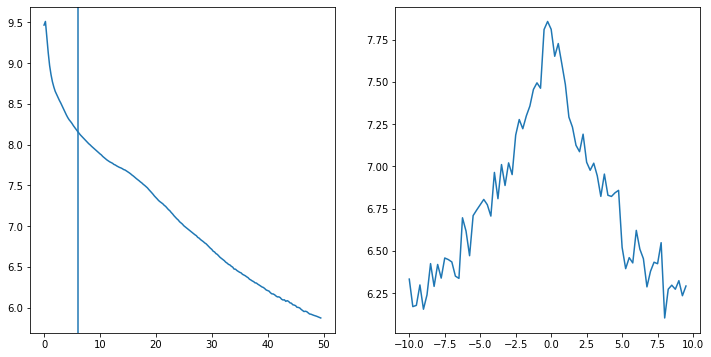

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(Rsd,np.log10(SD))
plt.axvline(0.5*Rhalf)

plt.subplot(122)
plt.plot(Zsd,np.log10(SDz))


In [38]:
import BreakFinder as bf
nonan = ~((np.log10(SD)==np.inf)|(np.log10(SD)==-np.inf))
cut=Rsd>=Rhalf*0.5
galaxy = bf.breaks(Rsd[nonan&cut],np.log10(SD[nonan&cut]),Rsd[nonan&cut])


OneExp = galaxy.PureExp()

bounds=((Rhalf,0,0,0),(Rsd.max(),np.inf,np.inf,np.inf))
DoubleExp = galaxy.DoubleExp(bounds=bounds)

nonanz = ~((np.log10(SDz)==np.inf)|(np.log10(SDz)==-np.inf))
Sechz = HeightPro(Zsd[nonanz],np.log10(SDz[nonanz]))

galz = bf.breaks(np.abs(Zsd[nonanz]),np.log10(SDz[nonanz]),Zsd[nonanz])
ZExp = galz.PureExp()

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


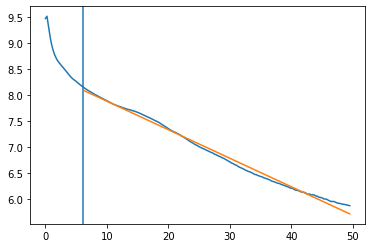

In [30]:
plt.plot(Rsd,np.log10(SD))
plt.axvline(0.5*Rhalf)
plt.plot(OneExp['LineFit'][0],OneExp['LineFit'][1])

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


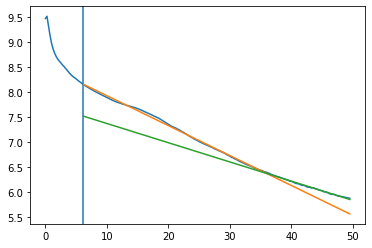

In [31]:
plt.plot(Rsd,np.log10(SD))
plt.axvline(0.5*Rhalf)
plt.plot(DoubleExp['LineFit_in'][0],DoubleExp['LineFit_in'][1])
plt.plot(DoubleExp['LineFit_out'][0],DoubleExp['LineFit_out'][1])

/u/svarel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


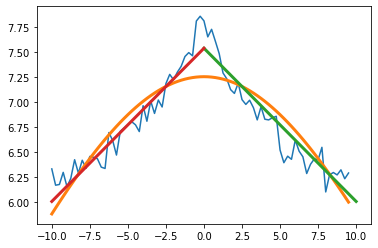

In [42]:
plt.plot(Zsd,np.log10(SDz))
plt.plot(Sechz['SechFit'][0],Sechz['SechFit'][1],lw=3)
plt.plot(ZExp['LineFit'][0],ZExp['LineFit'][1],lw=3)
plt.plot(-ZExp['LineFit'][0],ZExp['LineFit'][1],lw=3)

In [51]:
print('''__________
PureExp
hr  %.3f  [kpc]

DoubleExp
hi  %.3f  [kpc]
ho  %.3f  [kpc]
--------
Sechsq
hz  %.3f  [kpc]

absZ Exp
hz  %.3f  [kpc]
___________'''%(OneExp['h_i'],DoubleExp['h_i'],DoubleExp['h_o'],Sechz['h_z'],ZExp['h_i']))

__________
PureExp
hr  18.244  [kpc]

DoubleExp
hi  16.720  [kpc]
ho  26.020  [kpc]
--------
Sechsq
hz  21.470  [kpc]

absZ Exp
hz  6.532  [kpc]
___________


In [9]:
disk_config = """
---
id: cylinder
parameters:
  acyl: 0.01
  hcyl: 0.001
  lmax: 32
  mmax: 6
  nmax: 32
  ncylorder: 8
  ncylnx: 256
  ncylny: 128
  rnum: 200
  pnum: 0
  tnum: 80
  ashift: 0.5
  vflag: 0
  logr: false
  density: false
  eof_file: .eof.cache.run0
...
"""